In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

from scipy import stats
from IPython.display import Image

sys.path.append(os.path.expanduser('~/git/Python/user_modules/'))
from match_coord import match_coord

import select_desi_targets

In [2]:
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
ramin, ramax, decmin, decmax = 147.8+1.2, 152.5-1.2, -0.1+1.2, 4.5-1.2
nmad = lambda x: 1.4826*np.nanmedian(np.abs(x-np.nanmedian(x)))

In [4]:
truth = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/imaging_mc/subsets/cosmos_truth_clean.fits'))
print(len(truth))

# Remove objects with large sky residuals
for band in ['g', 'r', 'i', 'z']:
    truth[band+'_sky'] = (truth['apflux_blobresid_'+band][:, -1]-truth['apflux_blobresid_'+band][:, -2]) / (np.pi*7**2-np.pi*5**2)
mask = (truth['g_sky']>-0.002) & (truth['g_sky']<0.002)
print(np.sum(mask)/len(mask))
mask &= (truth['r_sky']>-0.003) & (truth['r_sky']<0.003)
print(np.sum(mask)/len(mask))
mask &= (truth['z_sky']>-0.006) & (truth['z_sky']<0.006)
print(np.sum(mask)/len(mask))
truth = truth[mask]
print(len(truth))

# Only keep isolated sources
mask = (truth['fracflux_g']>-0.01) & (truth['fracflux_g']<0.01)
print(np.sum(mask)/len(mask))
mask &= (truth['fracflux_r']>-0.01) & (truth['fracflux_r']<0.01)
print(np.sum(mask)/len(mask))
mask &= (truth['fracflux_z']>-0.01) & (truth['fracflux_z']<0.01)
print(np.sum(mask)/len(mask))
truth = truth[mask]
print(len(truth))

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    truth['gmag'] = 22.5 - 2.5*np.log10(truth['flux_g']) - 3.214 * truth['ebv']
    truth['rmag'] = 22.5 - 2.5*np.log10(truth['flux_r']) - 2.165 * truth['ebv']
    truth['zmag'] = 22.5 - 2.5*np.log10(truth['flux_z']) - 1.211 * truth['ebv']
    truth['w1mag'] = 22.5 - 2.5*np.log10(truth['flux_w1']) - 0.184 * truth['ebv']
    truth['w2mag'] = 22.5 - 2.5*np.log10(truth['flux_w2']) - 0.113 * truth['ebv']
    truth['gmagerr'] = 1/np.sqrt(truth['flux_ivar_g'])/(truth['flux_g'])
    truth['rmagerr'] = 1/np.sqrt(truth['flux_ivar_r'])/(truth['flux_r'])
    truth['zmagerr'] = 1/np.sqrt(truth['flux_ivar_z'])/(truth['flux_z'])
    truth['w1magerr'] = 1/np.sqrt(truth['flux_ivar_w1'])/(truth['flux_w1'])
    truth['w2magerr'] = 1/np.sqrt(truth['flux_ivar_w2'])/(truth['flux_w2'])
    truth['gfibermag'] = 22.5 - 2.5*np.log10(truth['fiberflux_g']) - 3.214 * truth['ebv']
    truth['rfibermag'] = 22.5 - 2.5*np.log10(truth['fiberflux_r']) - 2.165 * truth['ebv']
    truth['zfibermag'] = 22.5 - 2.5*np.log10(truth['fiberflux_z']) - 1.211 * truth['ebv']

truth_all = truth.copy()

1149893
0.9835628184535431
0.9732009847872802
0.9615285943996529
1105655
0.12092017853670449
0.09708724692603027
0.07313583351045308
80863


In [5]:
subs = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/data/deep_field_subsets/catalogs/cosmos_subsets_rongpu_dr10.fits'))
print(len(subs))

min_nobs = 1
mask = (subs['ngood_g']>=min_nobs) & (subs['ngood_r']>=min_nobs) & (subs['ngood_z']>=min_nobs)
subs = subs[mask]
print(len(subs))

tmp = Table()
tmp['sub'], tmp['count'] = np.unique(subs['sub'], return_counts=True)
tmp

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    subs['gmag'] = 22.5 - 2.5*np.log10(subs['flux_g']) - 3.214 * subs['ebv']
    subs['rmag'] = 22.5 - 2.5*np.log10(subs['flux_r']) - 2.165 * subs['ebv']
    subs['zmag'] = 22.5 - 2.5*np.log10(subs['flux_z']) - 1.211 * subs['ebv']
    subs['w1mag'] = 22.5 - 2.5*np.log10(subs['flux_w1']) - 0.184 * subs['ebv']
    subs['w2mag'] = 22.5 - 2.5*np.log10(subs['flux_w2']) - 0.113 * subs['ebv']
    subs['gmagerr'] = 1/np.sqrt(subs['flux_ivar_g'])/(subs['flux_g'])
    subs['rmagerr'] = 1/np.sqrt(subs['flux_ivar_r'])/(subs['flux_r'])
    subs['zmagerr'] = 1/np.sqrt(subs['flux_ivar_z'])/(subs['flux_z'])
    subs['w1magerr'] = 1/np.sqrt(subs['flux_ivar_w1'])/(subs['flux_w1'])
    subs['w2magerr'] = 1/np.sqrt(subs['flux_ivar_w2'])/(subs['flux_w2'])
    subs['gfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_g']) - 3.214 * subs['ebv']
    subs['rfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_r']) - 2.165 * subs['ebv']
    subs['zfibermag'] = 22.5 - 2.5*np.log10(subs['fiberflux_z']) - 1.211 * subs['ebv']

3183343
2752104


In [6]:
mask = subs['sub']=='dr9_ccds'
sub = subs[mask].copy()
print(len(sub))

242278


Doubly matched objects = 2
Final matched objects = 41202


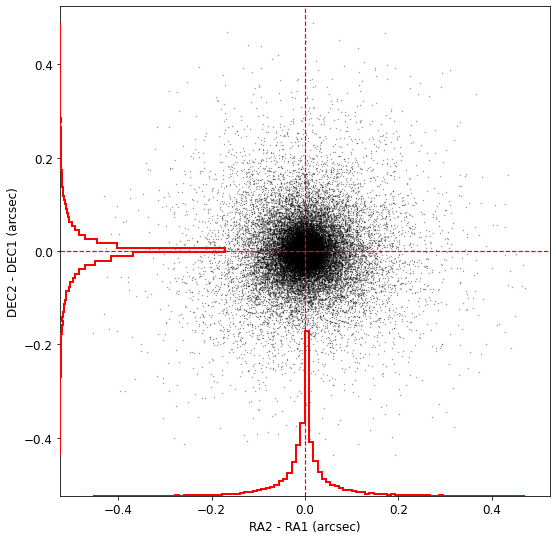

In [7]:
idx1, idx2, d2d, d_ra, d_dec = match_coord(truth['ra'], truth['dec'], sub['ra'], sub['dec'], search_radius=0.5, plot_q=True)

truth = truth[idx1]
sub = sub[idx2]

227733
Doubly matched objects = 0
Final matched objects = 35364


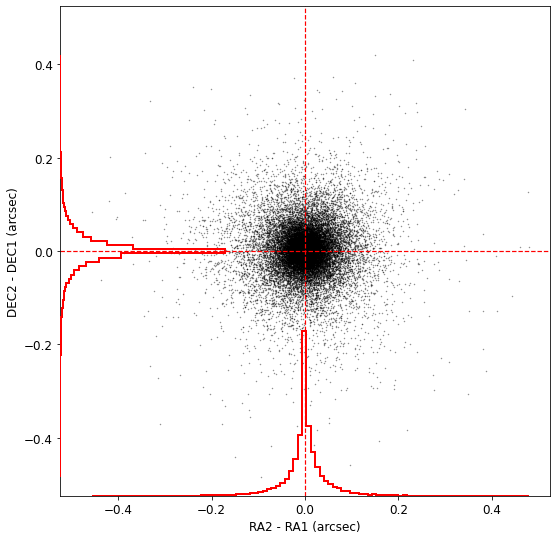

933 281


In [8]:
# Use a different subset to select an unbiased ELG sample
mask = subs['sub']=='sub-5'
sub1 = subs[mask].copy()
print(len(sub1))

idx1, idx2, d2d, d_ra, d_dec = match_coord(sub1['ra'], sub1['dec'], truth['ra'], truth['dec'], search_radius=0.5, plot_q=True)
sub1 = sub1[idx1]
sub = sub[idx2]
truth = truth[idx2]
elglop, elgvlo = select_desi_targets.select_elgs(sub1)
print(np.sum(elglop), np.sum(elgvlo))

In [11]:
mask0 = elglop.copy()

tmp1 = Table()
tmp1['type'], tmp1['count_1'] = np.unique(truth['type'][mask0], return_counts=True)
tmp1['frac_1'] = tmp1['count_1']/np.sum(mask0)*100
tmp1['frac_1'].format = '%.1f'

tmp2 = Table()
tmp2['type'], tmp2['count_2'] = np.unique(sub['type'][mask0], return_counts=True)
tmp2['frac_2'] = tmp2['count_2']/np.sum(mask0)*100
tmp2['frac_2'].format = '%.1f'

tmp = join(tmp1, tmp2, keys='type', join_type='outer')

tmp['frac_agree_1'] = 0.
tmp['frac_agree_1'].format = '%.1f'
tmp['frac_agree_2'] = 0.
tmp['frac_agree_2'].format = '%.1f'
for index, tt in enumerate(tmp['type']):
    mask = mask0 & (truth['type']==tt) & (sub['type']==tt)
    tmp['frac_agree_1'][index] = np.sum(mask) / np.sum(truth['type'][mask0]==tt) * 100
    tmp['frac_agree_2'][index] = np.sum(mask) / np.sum(sub['type'][mask0]==tt) * 100
    
tmp = tmp[['type', 'count_1', 'count_2', 'frac_1', 'frac_2', 'frac_agree_1', 'frac_agree_2']]
tmp.pprint_all()

type count_1 count_2 frac_1 frac_2 frac_agree_1 frac_agree_2
---- ------- ------- ------ ------ ------------ ------------
 DEV      23       5    2.5    0.5          4.3         20.0
 EXP      96      77   10.3    8.3         15.6         19.5
 PSF     240     354   25.7   37.9         90.4         61.3
 REX     480     496   51.4   53.2         73.8         71.4
 SER      94       1   10.1    0.1          1.1        100.0


In [12]:
mask0 = elglop.copy()
mask0 &= sub1['gfibermag']>23.6

tmp1 = Table()
tmp1['type'], tmp1['count_1'] = np.unique(truth['type'][mask0], return_counts=True)
tmp1['frac_1'] = tmp1['count_1']/np.sum(mask0)*100
tmp1['frac_1'].format = '%.1f'

tmp2 = Table()
tmp2['type'], tmp2['count_2'] = np.unique(sub['type'][mask0], return_counts=True)
tmp2['frac_2'] = tmp2['count_2']/np.sum(mask0)*100
tmp2['frac_2'].format = '%.1f'

tmp = join(tmp1, tmp2, keys='type', join_type='outer')

tmp['frac_agree_1'] = 0.
tmp['frac_agree_1'].format = '%.1f'
tmp['frac_agree_2'] = 0.
tmp['frac_agree_2'].format = '%.1f'
for index, tt in enumerate(tmp['type']):
    mask = mask0 & (truth['type']==tt) & (sub['type']==tt)
    tmp['frac_agree_1'][index] = np.sum(mask) / np.sum(truth['type'][mask0]==tt) * 100
    tmp['frac_agree_2'][index] = np.sum(mask) / np.sum(sub['type'][mask0]==tt) * 100
    
tmp = tmp[['type', 'count_1', 'count_2', 'frac_1', 'frac_2', 'frac_agree_1', 'frac_agree_2']]
tmp.pprint_all()

type count_1 count_2 frac_1 frac_2 frac_agree_1 frac_agree_2
---- ------- ------- ------ ------ ------------ ------------
 DEV      16      --    2.9     --          0.0          nan
 EXP      73      28   13.3    5.1          6.8         17.9
 PSF      88     185   16.1   33.8         87.5         41.6
 REX     317     335   57.8   61.1         69.7         66.0
 SER      54      --    9.9     --          0.0          nan


/tmp/ipykernel_111939/2200076284.py:23: RuntimeWarning: invalid value encountered in long_scalars
  tmp['frac_agree_2'][index] = np.sum(mask) / np.sum(sub['type'][mask0]==tt) * 100


In [13]:
mask0 = elglop.copy()

for tt in np.unique(truth['type']):
    mask = mask0 & (truth['type']==tt)
    print(tt, np.sum(mask))
    tmp = Table()
    tmp['type'], tmp['count'] = np.unique(sub['type'][mask], return_counts=True)
    tmp['frac (%)'] = tmp['count']/np.sum(mask)*100
    tmp['frac (%)'].format = '%.1f'
    tmp.sort('count')
    tmp.pprint_all()
    print()

DEV 23
type count frac (%)
---- ----- --------
 DEV     1      4.3
 EXP     1      4.3
 REX     8     34.8
 PSF    13     56.5

EXP 96
type count frac (%)
---- ----- --------
 DEV     1      1.0
 PSF     9      9.4
 EXP    15     15.6
 REX    71     74.0

PSF 240
type count frac (%)
---- ----- --------
 EXP     3      1.2
 REX    20      8.3
 PSF   217     90.4

REX 480
type count frac (%)
---- ----- --------
 DEV     3      0.6
 EXP     9      1.9
 PSF   114     23.8
 REX   354     73.8

SER 94
type count frac (%)
---- ----- --------
 PSF     1      1.1
 SER     1      1.1
 REX    43     45.7
 EXP    49     52.1



----------
## All subsets

In [15]:
for subset_index in range(10):
    
    print('sub-{}'.format(subset_index))
    
    truth = truth_all.copy()

    mask = subs['sub']=='sub-{}'.format(subset_index)
    sub = subs[mask].copy()

    idx1, idx2, d2d, d_ra, d_dec = match_coord(truth['ra'], truth['dec'], sub['ra'], sub['dec'], search_radius=0.5, plot_q=False, verbose=False)

    truth = truth[idx1]
    sub = sub[idx2]

    # Use a different subset to select an unbiased ELG sample
    mask = subs['sub']=='dr9_ccds'
    sub3 = subs[mask].copy()
    # print(len(sub3))

    idx1, idx2, d2d, d_ra, d_dec = match_coord(sub3['ra'], sub3['dec'], truth['ra'], truth['dec'], search_radius=0.5, plot_q=False, verbose=False)
    truth = truth[idx2]
    sub = sub[idx2]
    sub3 = sub3[idx1]
    elglop, elgvlo = select_desi_targets.select_elgs(sub3)
    # print(np.sum(elglop), np.sum(elgvlo))

    mask0 = elglop.copy()

    print('psfsize_g: {:.3f}  {:.3f}  {:.3f}'.format(np.median(truth['psfsize_g'][mask0]), np.median(sub['psfsize_g'][mask0]), np.median(truth['psfsize_g'][mask0])-np.median(sub['psfsize_g'][mask0])))
    print('psfsize_r: {:.3f}  {:.3f}  {:.3f}'.format(np.median(truth['psfsize_r'][mask0]), np.median(sub['psfsize_r'][mask0]), np.median(truth['psfsize_r'][mask0])-np.median(sub['psfsize_r'][mask0])))
    print('psfsize_z: {:.3f}  {:.3f}  {:.3f}'.format(np.median(truth['psfsize_z'][mask0]), np.median(sub['psfsize_z'][mask0]), np.median(truth['psfsize_z'][mask0])-np.median(sub['psfsize_z'][mask0])))

    tmp1 = Table()
    tmp1['type'], tmp1['count_1'] = np.unique(truth['type'][mask0], return_counts=True)
    tmp1['frac_1'] = tmp1['count_1']/np.sum(mask0)*100
    tmp1['frac_1'].format = '%.1f'

    tmp2 = Table()
    tmp2['type'], tmp2['count_2'] = np.unique(sub['type'][mask0], return_counts=True)
    tmp2['frac_2'] = tmp2['count_2']/np.sum(mask0)*100
    tmp2['frac_2'].format = '%.1f'

    tmp = join(tmp1, tmp2, keys='type', join_type='outer')

    tmp['frac_agree_1'] = 0.
    tmp['frac_agree_1'].format = '%.1f'
    tmp['frac_agree_2'] = 0.
    tmp['frac_agree_2'].format = '%.1f'
    for index, tt in enumerate(tmp['type']):
        mask = mask0 & (truth['type']==tt) & (sub['type']==tt)
        tmp['frac_agree_1'][index] = np.sum(mask) / np.sum(truth['type'][mask0]==tt) * 100
        tmp['frac_agree_2'][index] = np.sum(mask) / np.sum(sub['type'][mask0]==tt) * 100
        
    tmp = tmp[['type', 'count_1', 'count_2', 'frac_1', 'frac_2', 'frac_agree_1', 'frac_agree_2']]
    tmp.pprint_all()

    print()
    print()

sub-0
psfsize_g: 1.310  1.636  -0.327
psfsize_r: 1.196  1.217  -0.021
psfsize_z: 1.220  1.146  0.074
type count_1 count_2 frac_1 frac_2 frac_agree_1 frac_agree_2
---- ------- ------- ------ ------ ------------ ------------
 DEV      14      --    2.1     --          0.0          nan
 EXP      69      23   10.1    3.4          4.3         13.0
 PSF     166     331   24.3   48.5         96.4         48.3
 REX     361     328   52.9   48.1         62.3         68.6
 SER      72      --   10.6     --          0.0          nan


sub-1


/tmp/ipykernel_111939/231296741.py:52: RuntimeWarning: invalid value encountered in long_scalars
  tmp['frac_agree_2'][index] = np.sum(mask) / np.sum(sub['type'][mask0]==tt) * 100


psfsize_g: 1.310  1.428  -0.118
psfsize_r: 1.196  1.064  0.132
psfsize_z: 1.220  1.146  0.074
type count_1 count_2 frac_1 frac_2 frac_agree_1 frac_agree_2
---- ------- ------- ------ ------ ------------ ------------
 DEV      19       5    2.6    0.7          0.0          0.0
 EXP      70      59    9.5    8.0         17.1         20.3
 PSF     187     293   25.3   39.7         92.5         59.0
 REX     385     380   52.2   51.5         71.2         72.1
 SER      77       1   10.4    0.1          1.3        100.0


sub-2
psfsize_g: 1.311  1.187  0.124
psfsize_r: 1.197  1.486  -0.289
psfsize_z: 1.222  1.129  0.093
type count_1 count_2 frac_1 frac_2 frac_agree_1 frac_agree_2
---- ------- ------- ------ ------ ------------ ------------
 DEV      20       7    2.2    0.8          0.0          0.0
 EXP      92      77   10.0    8.4         17.4         20.8
 PSF     234     373   25.5   40.7         94.9         59.5
 REX     476     458   52.0   50.0         71.2         74.0
 SER      9